In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets
from torchmetrics import Accuracy, Precision, Recall
from torchvision.datasets import ImageFolder

In [26]:
train_path = "Training"
test_path = "Testing"

In [27]:
image_size = (224,224)

In [28]:
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10),
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [29]:
dataset_train = ImageFolder(root = train_path,transform = train_transforms)
dataset_test = ImageFolder(root = test_path,transform = test_transforms)

In [60]:
dataloader_train = DataLoader(
  dataset_train, shuffle=True, batch_size=32
)
dataloader_test = DataLoader(dataset_test,shuffle = True, batch_size = 32)

In [100]:
visualize_loader = DataLoader(
  dataset_test, shuffle=True, batch_size=1
)

In [101]:
def show_image(input_images, label,mean=None, std=None):
    """
    Display a single denormalized image with its label.

    Args:
        input_images (Tensor): A single image tensor or a batch (N, C, H, W).
        label (int): The label index for the image.
        dataset_train: Dataset object to access class names.
        mean (list): Mean used for normalization (default: ImageNet mean).
        std (list): Std dev used for normalization (default: ImageNet std dev).
    """
    # Default mean and std if not provided
    if mean is None:
        mean = [0.485, 0.456, 0.406]
    if std is None:
        std = [0.229, 0.224, 0.225]

    # If input is a batch, select the first image
    if len(input_images.shape) == 4:  # Batch of images: (N, C, H, W)
        input_images = input_images[0]  # Select the first image

    # Convert from (C, H, W) to (H, W, C)
    input_images = input_images.numpy().transpose((1, 2, 0))

    # Denormalize the image
    input_images = std * input_images + mean
    input_images = np.clip(input_images, 0, 1)  # Ensure pixel values are in range [0, 1]

    # Display the image
    plt.imshow(input_images)
    plt.title(f'Label: {dataset_train.classes[label]}')  # Display label name
    plt.axis('off')  # Hide axes
    plt.show()

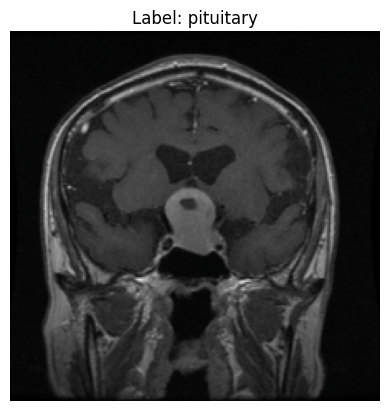

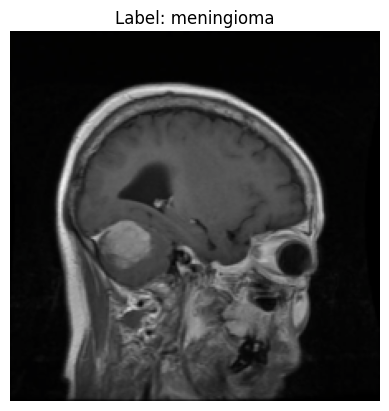

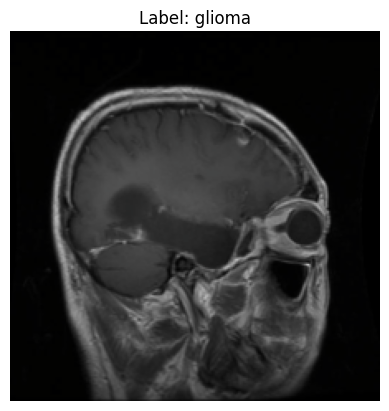

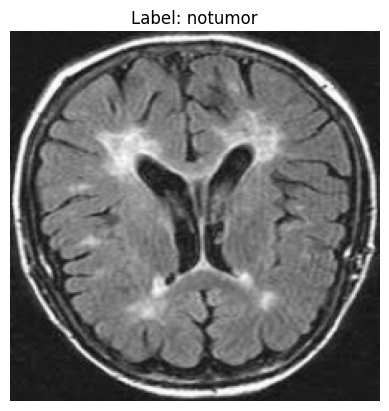

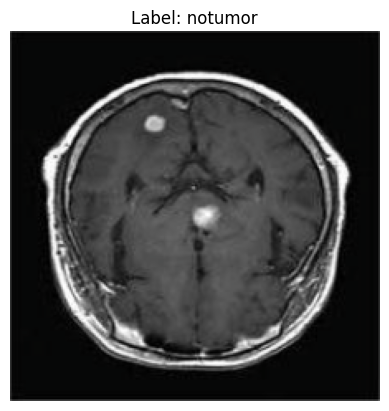

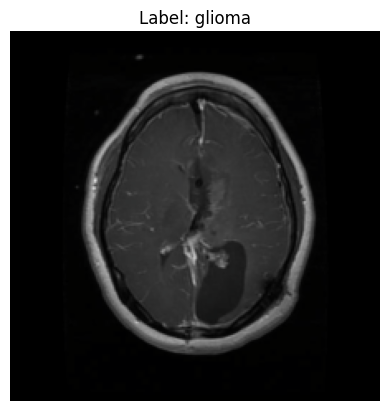

In [102]:
for i in range(6):
    images,labels = next(iter(visualize_loader))
    show_image(images,labels)

In [25]:
image_size = dataset_train[0][0].shape[1]

In [85]:
image_size = dataset_train[0][0].shape[1]
class CNN(nn.Module):
    def __init__(self,num_classes):
        super(CNN,self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=4,stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4,stride=1, padding=0)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=4,stride=1, padding=0)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=4,stride=1, padding=0)
        self.bn4 = nn.BatchNorm2d(128)
        self.elu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3,stride = 3)
        self.maxpool2= nn.MaxPool2d(kernel_size=3, stride=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(6*6*128,512, num_classes)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, num_classes)
    def forward(self,x):
        x = self.elu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)
        x = self.elu(self.bn2(self.conv2(x)))
        x = self.maxpool(x)
        x = self.elu(self.bn3(self.conv3(x)))
        x = self.maxpool2(x)
        x = self.elu(self.bn4(self.conv4(x)))
        x = self.flatten(x)
        x = self.elu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [86]:
train_history = []
test_history = []
loss_history = []

In [87]:
import torch
import torch.nn as nn
import torch.optim as optim


def train_and_evaluate(model, train_loader, test_loader, device, num_epochs=10, learning_rate=1e-3):
    """
    Train a PyTorch model and display train and test accuracy at each epoch.

    Args:
        model: PyTorch model to be trained.
        train_loader: DataLoader for training data.
        test_loader: DataLoader for testing data.
        device: Device to run the model ("cpu" or "cuda").
        num_epochs: Number of epochs for training.
        learning_rate: Learning rate for the optimizer.
    """
    # Move the model to the specified device
    model = model.to(device)

    # Define the loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_correct = 0
        train_total = 0
        running_loss = 0.0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Update metrics
            running_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            train_correct += (preds == labels).sum().item()
            train_total += labels.size(0)

        train_accuracy = train_correct / train_total
        train_history.append(train_accuracy)

        # Testing phase
        model.eval()
        test_correct = 0
        test_total = 0

        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                # Forward pass
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)

                # Update metrics
                test_correct += (preds == labels).sum().item()
                test_total += labels.size(0)

        test_accuracy = test_correct / test_total
        test_history.append(test_accuracy)
        loss = running_loss / len(train_loader)
        loss_history.append(loss)

        # Display epoch results
        print(f"Epoch [{epoch + 1}/{num_epochs}]"
              f" - Loss: {loss:.4f}"
              f" - Train Accuracy: {train_accuracy:.4f}"
              f" - Test Accuracy: {test_accuracy:.4f}")


# Example usage:
# Assuming you have `train_loader`, `test_loader`, and a defined `model`.
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# train_and_evaluate(model, train_loader, test_loader, device, num_epochs=10, learning_rate=1e-3)


In [88]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [89]:
model = CNN(4)
train_and_evaluate(model, dataloader_train, dataloader_test, device, num_epochs=40, learning_rate=0.0002)
torch.save(model.state_dict(), "Tumor_model.pth")

Epoch [1/40] - Loss: 0.5795 - Train Accuracy: 0.7729 - Test Accuracy: 0.7597
Epoch [2/40] - Loss: 0.3713 - Train Accuracy: 0.8624 - Test Accuracy: 0.8612
Epoch [3/40] - Loss: 0.3002 - Train Accuracy: 0.8915 - Test Accuracy: 0.8604
Epoch [4/40] - Loss: 0.2517 - Train Accuracy: 0.9048 - Test Accuracy: 0.7841
Epoch [5/40] - Loss: 0.2161 - Train Accuracy: 0.9216 - Test Accuracy: 0.8055
Epoch [6/40] - Loss: 0.1823 - Train Accuracy: 0.9347 - Test Accuracy: 0.8413
Epoch [7/40] - Loss: 0.1766 - Train Accuracy: 0.9352 - Test Accuracy: 0.8673
Epoch [8/40] - Loss: 0.1583 - Train Accuracy: 0.9417 - Test Accuracy: 0.8635
Epoch [9/40] - Loss: 0.1376 - Train Accuracy: 0.9492 - Test Accuracy: 0.8986
Epoch [10/40] - Loss: 0.1441 - Train Accuracy: 0.9463 - Test Accuracy: 0.9451
Epoch [11/40] - Loss: 0.1161 - Train Accuracy: 0.9564 - Test Accuracy: 0.9161
Epoch [12/40] - Loss: 0.0981 - Train Accuracy: 0.9620 - Test Accuracy: 0.9672
Epoch [13/40] - Loss: 0.0929 - Train Accuracy: 0.9667 - Test Accuracy: 0.

In [90]:
# Load the model later for inference
model = CNN(4)  # Recreate the architecture
model.load_state_dict(torch.load("Tumor_model.pth"))
model.to(device)
model.eval()  # Set the model to evaluation mode
print("Model loaded and ready for inference")

Model loaded and ready for inference


/var/folders/38/jnyszq9x60bbsss6fj5vm1gr0000gn/T/ipykernel_22444/403369368.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("Tumor_model.

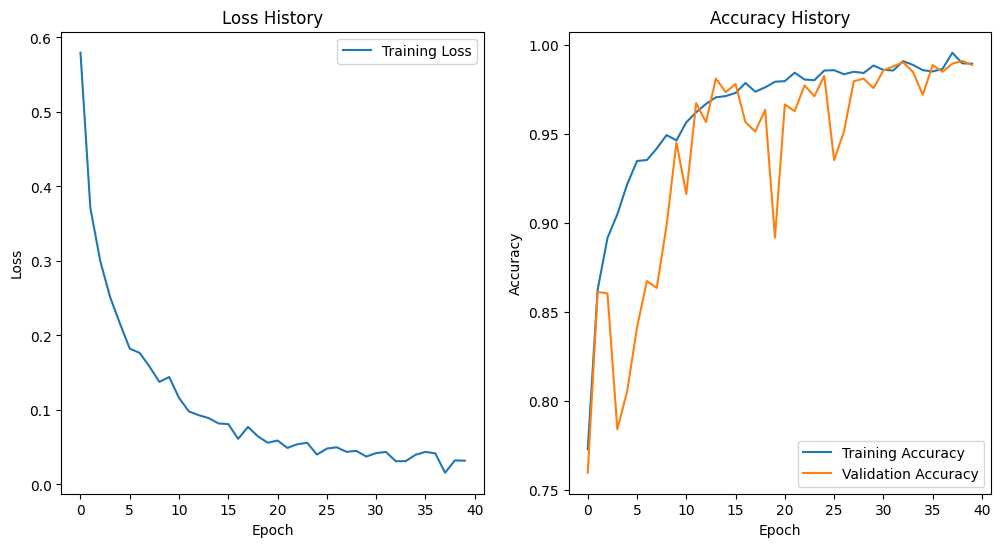

In [99]:
# Visualize training history
plt.figure(figsize=(12, 6))
plt.subplot(1, 2,1)
plt.plot(loss_history, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss History')

plt.subplot(1, 2, 2)
plt.plot(train_history, label='Training Accuracy')
plt.plot(test_history, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy History')

plt.show()